In [1]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# **Reading the CSV files**

In [2]:
# Read the CSV file
filenames = ['sensex_1990_to_2014.csv',
             'nifty_1994_to_2014.csv',
             'nifty_2000_to_2024.csv']

file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_2000_to_2024.csv'

data = pd.read_csv(file_name)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,5291.749764,5336.862885,5241.120997,5290.119381,5290.119381,38655.058824
std,996.396802,989.287755,1003.653913,996.116806,996.116806,74383.681317
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000
25%,4882.237305,4935.449829,4835.637451,4887.637451,4887.637451,0.000000
50%,5342.224854,5382.899902,5297.350098,5334.349854,5334.349854,0.000000
75%,5888.749878,5923.625122,5844.474976,5889.887451,5889.887451,0.000000
max,7942.250000,7968.250000,7939.200195,7954.350098,7954.350098,437000.000000


# **Calculate the Technical Indicator**

In [4]:
# Define the parameters
sma_window_size = 3
ema_smoothing_param = 0.2
williams_r_window_size = 3
RSI_window_size = 14
ATR_window_size = 14
VR_window_size = 14

k_param = 10                 # Defining the k parameter for KNN algorithm
training_set_ratio = 0.9     # Defining the training set for KNN algorithm
enable_knn_normalization = True

In [5]:
def williams_r(highs, lows, closes, window):
    highest_high = highs.rolling(window=window).max()
    lowest_low = lows.rolling(window=window).min()
    r = ((highest_high - closes) / (highest_high - lowest_low)) * -100
    return r

def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, window):
    tr1 = data['High'] - data['Low']
    tr2 = abs(data['High'] - data['Close'].shift(1))
    tr3 = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def calculate_vr(data, window):
    tr = data['High'] - data['Low']
    tr_prev = tr.shift(1).rolling(window=window).mean()
    vr = tr / tr_prev
    return vr

def TI_calculations(data):
    data['returns'] = -data['Close'].diff(-1)
    data['SMA_Close'] = data['Close'].rolling(window=sma_window_size).mean()
    data['EMA_Close'] = data['Close'].ewm(alpha=ema_smoothing_param).mean()
    data['Williams %R'] = williams_r(data['High'], data['Low'], data['Close'], window=williams_r_window_size)
    data['RSI'] = calculate_rsi(data, window=RSI_window_size)
    data['ATR'] = calculate_atr(data, window=ATR_window_size)
    data['VR'] = calculate_vr(data, window=VR_window_size)
    data.drop(columns=['Date'],inplace=True)
    
    # Remove non-numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    data.dropna(inplace = True)
    return data

data = TI_calculations(data)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,returns,SMA_Close,EMA_Close,Williams %R,RSI,ATR,VR
1694,7875.350098,7919.649902,7855.950195,7891.100098,7891.100098,115200,22.100098,7887.966634,7812.602957,-47.340970,60.512647,83.789237,0.859313
1695,7904.549805,7929.049805,7900.049805,7913.200195,7913.200195,104100,-6.900391,7893.200033,7832.722405,-21.682208,71.842467,77.399937,0.397727
1696,7931.750000,7968.250000,7897.950195,7906.299805,7906.299805,118500,-1.549805,7903.533366,7847.437885,-55.165007,67.480531,75.835658,1.061701
1697,7874.500000,7915.450195,7862.450195,7904.750000,7904.750000,142800,31.299805,7908.083333,7858.900308,-60.019014,63.744564,71.449916,0.802552
1698,7933.899902,7946.850098,7916.549805,7936.049805,7936.049805,120000,18.300293,7915.699870,7874.330207,-30.435023,74.798010,68.199951,0.491461


# **KNN Search with cosine similarity metrics**

In [6]:
train_set_length = int(training_set_ratio*data.shape[0])     # 90% of the data is used for training

**Algorithm**

1) The data is normalized first.Normalization ensure that the distance between two point for attribute 1 is in the same scale as the distance between any other two points.The distances only will be in the range 0 to 1.
2) The cosine similarity of the current day price,TIs(query) are calculated with respect to all the element training set.
3) The whole dataset is then sorted based on this training set in descending order and then the first 'k' row are returned.

Note : The higher the cosine value the more similar the vectors are.

In [7]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0  # To handle the case where one or both vectors are zero vectors
    
    return dot_product / (norm_vec1 * norm_vec2)
    
def knn_search(data,query,k,enable_normalization = enable_knn_normalization):
    # Scaling the data
    if enable_normalization:
        query = (query - data.min())/(data.max() - data.min())
        temp_data = (data - data.min())/(data.max() - data.min())
    else:
        temp_data = data
        
    data['distances'] = cosine_similarity(temp_data,query)
    sorted_data = data.sort_values(by='distances',ascending = False)
    #sorted_data = sorted_data.iloc[1:,:]   # Remove the first row of the dataframe because it is having distance value of 0.0

    return sorted_data.iloc[:k,:]

sorted_data = knn_search(data,data.iloc[-1,:],10)

In [8]:
sorted_data

,Open,High,Low,Close,Adj Close,Volume,returns,SMA_Close,EMA_Close,Williams %R,RSI,ATR,VR,distances
1698,7933.899902,7946.850098,7916.549805,7936.049805,7936.049805,120000,18.300293,7915.699870,7874.330207,-30.435023,74.798010,68.199951,0.491461,0.040203
1695,7904.549805,7929.049805,7900.049805,7913.200195,7913.200195,104100,-6.900391,7893.200033,7832.722405,-21.682208,71.842467,77.399937,0.397727,0.040152
1692,7901.000000,7918.549805,7881.149902,7897.500000,7897.500000,140600,-22.200195,7854.483398,7772.398388,-11.730197,58.431545,87.321394,0.471668,0.039913
1691,7785.250000,7880.500000,7779.200195,7874.250000,7874.250000,126700,23.250000,7801.833333,7741.122986,-3.382038,54.650897,89.674979,1.287922,0.039762
1676,7796.250000,7835.649902,7771.649902,7830.600098,7830.600098,117600,-40.149902,7798.066732,7708.470669,-3.859229,55.302013,102.396484,0.630431,0.039491
1663,7780.399902,7792.000000,7755.100098,7787.149902,7787.149902,173900,-163.949707,7751.183268,7675.115715,-3.710857,62.399273,80.075056,0.463337,0.039469
1662,7718.100098,7758.000000,7661.299805,7751.600098,7751.600098,113100,35.549805,7730.516602,7647.107168,-6.618293,65.813335,86.357213,1.254333,0.039432
1643,7621.649902,7673.700195,7580.250000,7654.600098,7654.600098,231900,1.799805,7570.700033,7450.352777,-6.098367,75.303701,106.139300,0.909586,0.039421
1683,7706.649902,7752.450195,7638.049805,7746.549805,7746.549805,128200,-74.500000,7677.599935,7713.605577,-3.721463,64.442408,84.960763,1.469025,0.039286
1675,7794.899902,7809.200195,7752.899902,7795.750000,7795.750000,122100,34.850098,7749.266764,7677.938312,-9.948355,55.418714,104.732213,0.557902,0.039265


In [9]:
estimated_price_dictionary = {}
actual_price_dictionary = {}
for file in filenames:
    data = pd.read_csv(file)
    data = TI_calculations(data)
    
    actual_close_price = []
    estimated_close_price = []
    for i in tqdm(range(data.shape[0]-train_set_length-1),desc = f"Processing {file} : "):
        data_for_search = data.iloc[i:i+train_set_length,:]
        query = data.iloc[i+train_set_length,:]
    
        sorted_data = knn_search(data_for_search,query,k_param)
        estimated_return = sorted_data['returns'].mean()
    
        estimated_close_price.append(query['Close'] + estimated_return)
        actual_close_price.append(data.iloc[i+train_set_length+1,:]['Close'])

    # Error metrics
    estimated_close_price = np.array(estimated_close_price)
    actual_close_price = np.array(actual_close_price)

    estimated_price_dictionary[file] = estimated_close_price
    actual_price_dictionary[file] = actual_close_price

Processing nifty_2000_to_2024.csv : 100%|██| 4437/4437 [00:11<00:00, 399.46it/s]


# **Visualization**

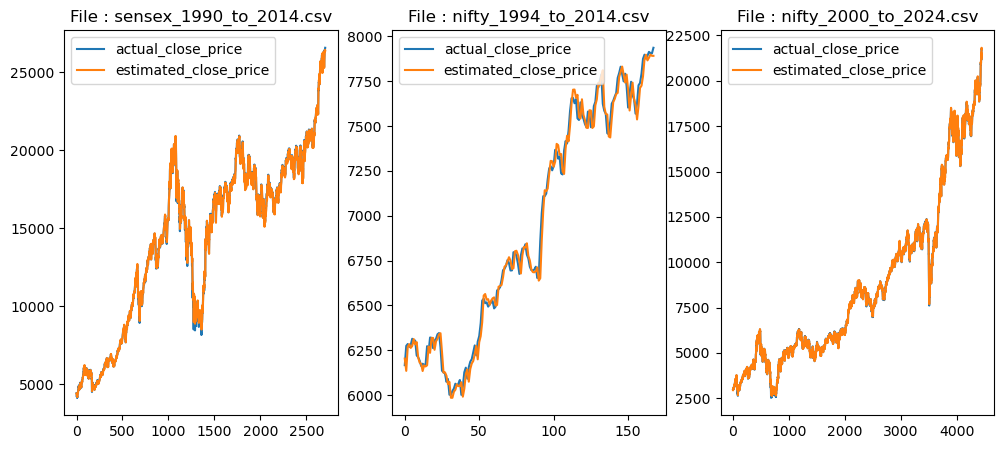

In [10]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]])
plt.plot(estimated_price_dictionary[filenames[0]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]])
plt.plot(estimated_price_dictionary[filenames[1]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]])
plt.plot(estimated_price_dictionary[filenames[2]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.show()

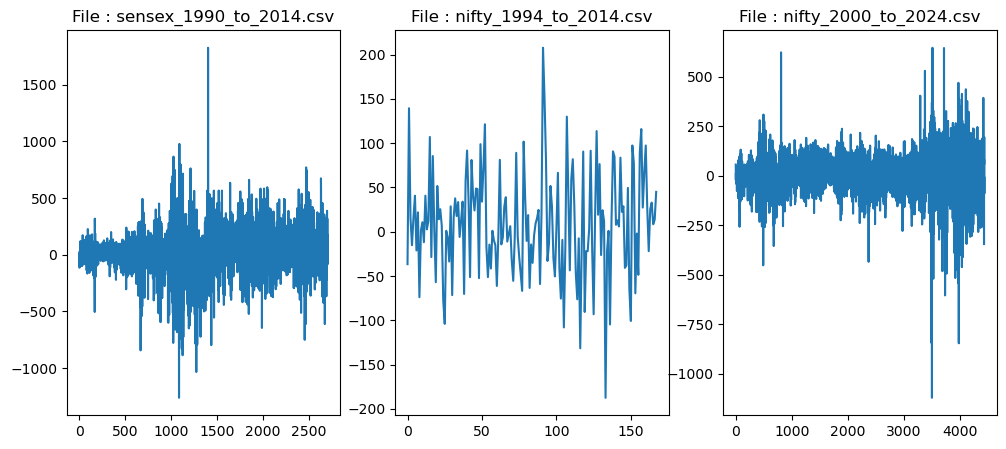

In [11]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]] - estimated_price_dictionary[filenames[0]])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]] - estimated_price_dictionary[filenames[1]])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]] - estimated_price_dictionary[filenames[2]])

plt.show()

In [12]:
for file in filenames:
    error = actual_price_dictionary[file] - estimated_price_dictionary[file]
    print(f"The rmse for {file} with enable_knn_normalization as {enable_knn_normalization} is {np.sqrt(np.mean(error**2))} <br>")

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 211.5111087341279 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 59.10590494581417 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 100.30611755211909 <br>


# **Result**

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 211.5111087341279 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 59.10590494581417 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 100.30611755211909 <br>

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as False is 220.99483490587588 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as False is 63.583018975456945 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as False is 109.96246417777405 <br>